# Working with 3D-data

Tobac also has the ability to process 3d data, but there are a few things to be considered. These will be covered in this notebook. We start by loading in the usual libraries:

In [2]:
import tobac
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

%matplotlib inline

An example of 3D-data can be produced by a build-in utility:

In [3]:
data = tobac.testing.make_sample_data_3D_3blobs()

In [4]:
data

<xarray.DataArray 'w' (time: 25, z: 20, y: 200, x: 100)>
[10000000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T12:48:00
  * z          (z) float64 0.0 1e+03 2e+03 3e+03 ... 1.7e+04 1.8e+04 1.9e+04
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 1.97e+05 1.98e+05 1.99e+05
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1

In general the visualisation is a bit more complicated with such datasets. If we want to have a look at it with imshow, we now need to specify two coordinates to achieve a 2D picture, and there are several possibilities to do that:

Text(0.5, 1.0, 'x = 0, y = 0')

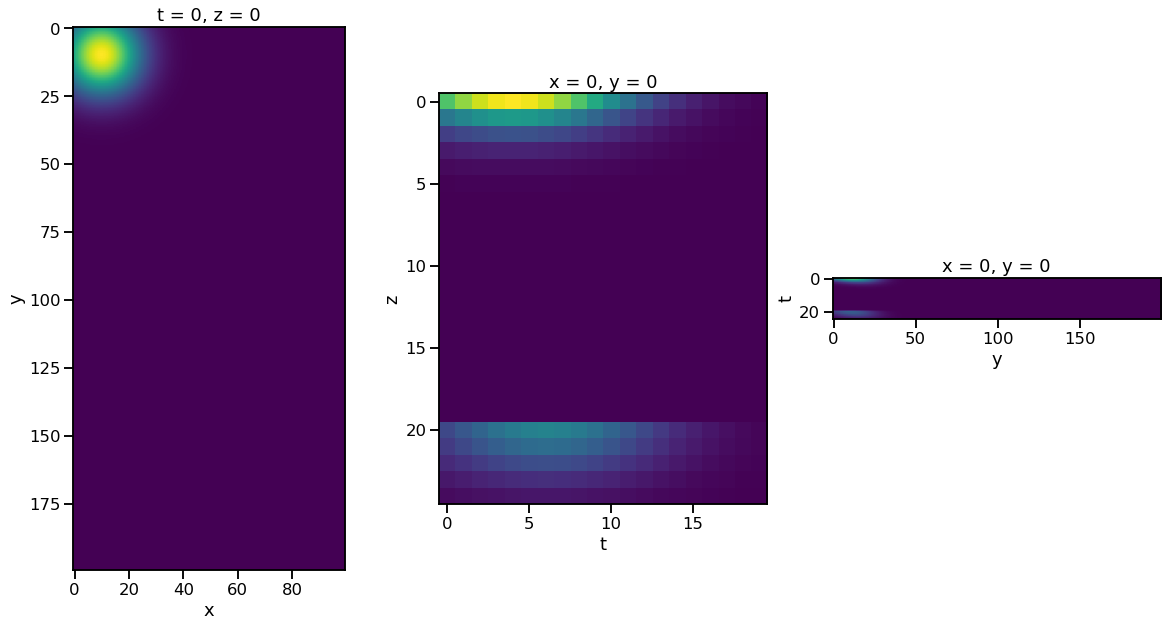

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (20, 10))

ax1.imshow(data[0, 0])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('t = 0, z = 0')

ax2.imshow(data[:, :, 0, 0])
ax2.set_xlabel('t')
ax2.set_ylabel('z')
ax2.set_title('x = 0, y = 0')

ax3.imshow(data[:, 0, :, 0])
ax3.set_xlabel('y')
ax3.set_ylabel('t')
ax3.set_title('x = 0, y = 0')

## Feature-detection

As before, the workfllow starts with feature detetection. Note, however, that only a **two dimensional** input is allowed for the *feature_detection_multithreshold()* function. Therefore, we create another dataset by selecting only points with the highest value of *z* from our generated field:

In [9]:
sample_data_max = data.max(dim="z")

Now the feature detection can be performed for this sub-dataset as usual:

In [12]:
%%capture
dxy, dt = tobac.utils.get_spacings(sample_data_max)
thresholds = 0.05
features = tobac.themes.tobac_v1.feature_detection_multithreshold(sample_data_max, dxy, 9)

The resulting feature object contains the 2d coordinates of the features in the sub-dataset.

In [13]:
features

<xarray.Dataset>
Dimensions:                  (index: 30)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
Data variables: (12/13)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 22 22 23 23 24 24
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 10.0 11.71 13.2 ... 15.78 50.27
    hdim_2                   (index) float64 10.0 13.66 17.11 ... 25.55 95.97
    num                      (index) int64 69 65 65 66 65 ... 66 500 65 504 59
    threshold_value          (index) int64 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9
    ...                       ...
    time                     (index) object 2000-01-01 12:00:00 ... 2000-01-0...
    timestr                  (index) object '2000-01-01 12:00:00' ... '2000-0...
    projection_y_coordinate  (index) float64 1e+04 1.171e+04 ... 5.027e+04
    projection_x_coordinate  (index) float64 1e+04 1.366e+04 ... 9.597e+04
    latitude                 (index) object 24.1 24.14 24.17 ... 24.26 24.96
    longitude                (index) object 150.1 150.1 150.1 ... 150.2 150.5

## Segmentation

The segmentation is performed on the 3D dataset, but with the features from the 2D feature detection. This means that only the features that are present in the partial data set are used as a starting point for the segmentation algorithm.

In [17]:
%%capture
mask, features_mask = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=thresholds)

The resulting mask of the segments does have 3 dimensions and therefore can be visualized similar to the field itself:

Text(0.5, 1.0, 'created segments')

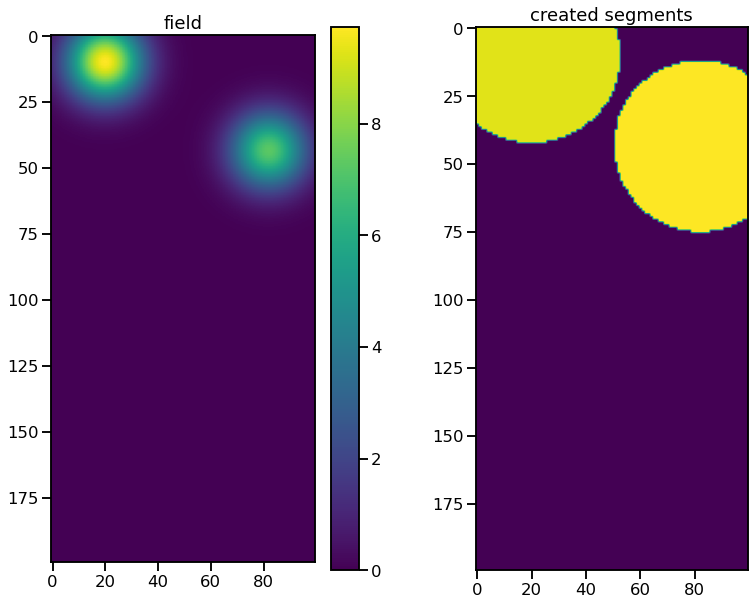

In [37]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (13, 10))

time = 20
z = 0

#fig.suptitle('z = {}'.format(z))

cs = ax1.imshow(data[time, z])
ax1.set_title('field')
plt.colorbar(cs, ax = ax1)

ax2.imshow(mask[time, z])
ax2.set_title('created segments')

### vertical_coord

Depending on your dataset it is possible to have more than one coordinate that could be used as the third dimension during the segmentation. Which one will be used can be specified with the *vertical_coord* parameter. The possible flags are 'auto, 'z', 'model_level_number', 'altitude' and 'geopotential_height', with 'auto' as the default. Which of them your dataset contains can be checked by transforming it to the iris format:

In [56]:
data.to_iris()

W (m s-1),time,geopotential_height,projection_y_coordinate,projection_x_coordinate
Shape,25,20,200,100
Dimension coordinates,,,,
time,x,-,-,-
geopotential_height,-,x,-,-
projection_y_coordinate,-,-,x,-
projection_x_coordinate,-,-,-,x
Auxiliary coordinates,,,,
latitude,-,-,x,x
longitude,-,-,x,x


As you can see, "geopotential_height" is the only possible option here and it would be selected automatically with auto', but we can also specify it explicitly:

In [57]:
mask, features_mask = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=thresholds, vertical_coord = "geopotential_height")

<xarray.DataArray 'w' (time: 25, z: 20, y: 200, x: 100)>
[10000000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T12:48:00
  * z          (z) float64 0.0 1e+03 2e+03 3e+03 ... 1.7e+04 1.8e+04 1.9e+04
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 1.97e+05 1.98e+05 1.99e+05
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1


Any other value for that parameter would result in an exception.

## Linking

The linking process works again with the 2 dimensional feature datasets. The field needs to be defined as input, but it does not affect the algorithm. Therefore the resulting tracks are again 2 dimensional and the parameters can therefore handled completely analogous to the 2D cases.

In [58]:
track = tobac.themes.tobac_v1.linking_trackpy(features, data, dt, dxy, v_max = 100)

Frame 24: 2 trajectories present.


In [59]:
track

<xarray.Dataset>
Dimensions:                  (index: 30)
Coordinates:
  * index                    (index) int64 0 1 2 3 4 5 6 ... 24 25 26 27 28 29
Data variables: (12/15)
    frame                    (index) int64 0 1 2 3 4 5 6 ... 22 22 23 23 24 24
    idx                      (index) int64 1 1 1 1 1 1 1 1 1 ... 1 2 1 2 1 2 1 2
    hdim_1                   (index) float64 10.0 11.71 13.2 ... 15.78 50.27
    hdim_2                   (index) float64 10.0 13.66 17.11 ... 25.55 95.97
    num                      (index) int64 69 65 65 66 65 ... 66 500 65 504 59
    threshold_value          (index) int64 9 9 9 9 9 9 9 9 9 ... 9 9 9 9 9 9 9 9
    ...                       ...
    projection_y_coordinate  (index) float64 1e+04 1.171e+04 ... 5.027e+04
    projection_x_coordinate  (index) float64 1e+04 1.366e+04 ... 9.597e+04
    latitude                 (index) object 24.1 24.14 24.17 ... 24.26 24.96
    longitude                (index) object 150.1 150.1 150.1 ... 150.2 150.5
    cell                     (index) float64 1.0 1.0 1.0 1.0 ... 2.0 1.0 2.0 1.0
    time_cell                (index) timedelta64[ns] 00:00:00 ... 00:48:00

**level parameter doesn't do anything?**

In [46]:
mask, features_mask = tobac.themes.tobac_v1.segmentation(features, data, dxy, threshold=thresholds, level = 'bananas')

<xarray.DataArray 'w' (time: 25, z: 20, y: 200, x: 100)>
[10000000 values with dtype=float64]
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01T12:00:00 ... 2000-01-01T12:48:00
  * z          (z) float64 0.0 1e+03 2e+03 3e+03 ... 1.7e+04 1.8e+04 1.9e+04
  * y          (y) float64 0.0 1e+03 2e+03 3e+03 ... 1.97e+05 1.98e+05 1.99e+05
  * x          (x) float64 0.0 1e+03 2e+03 3e+03 ... 9.7e+04 9.8e+04 9.9e+04
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
Attributes:
    units:    m s-1
